<h1><center>W2V SG Stability</center></h1>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import re
from pathlib import Path
from multiprocessing import cpu_count
from itertools import islice, chain

import pandas as pd
import numpy as np
import string

import gensim
from gensim.models import Word2Vec

from scipy.linalg import norm
from sklearn.decomposition import PCA

from tqdm.contrib.concurrent import process_map

from matplotlib import pyplot as plt

from transform import *
from callbacks import *
from utils import *

np.random.seed(2021)

In [3]:
DS_ROOT = Path("data/")
EVAL_ROOT = Path("eval_data/")
MODEL_ROOT = Path("models/")

In [4]:
gensim.__version__

'4.1.3.dev0'

## Data Preprocessing

In [5]:
!mkdir -p data

### Download & Parse Wikipedia Data

In [6]:
!python3 -m wikiextractor.WikiExtractor -h >/dev/null 2>&1 || pip install --user wikiextractor

In [7]:
![ -f "{DS_ROOT}/enwik8.zip" ] || [ -f "{DS_ROOT}/enwik8" ] || wget -P "{DS_ROOT}" http://cs.fit.edu/~mmahoney/compression/enwik8.zip
![ -f "{DS_ROOT}/enwik8.zip" ] && unzip -o -d "{DS_ROOT}" "{DS_ROOT}/enwik8.zip" && rm "{DS_ROOT}/enwik8.zip"
!head -n 10 "{DS_ROOT}/enwik8"
![ -f "{DS_ROOT}/enwik8_clean" ] || \
 ( echo "Extracting and cleaning {DS_ROOT}/enwik8 to {DS_ROOT}/enwik8_clean..." && \
   python3 -m wikiextractor.WikiExtractor "{DS_ROOT}/enwik8" --processes 8 -q -o - \
    | sed "/^\s*\$/d" \
    | grep -v "^<doc id=" \
    | grep -v "</doc>\$" \
    > "{DS_ROOT}/enwik8_clean" && \
    echo "Succesfully extracted and cleaned {DS_ROOT}/enwik8 to {DS_ROOT}/enwik8_clean" )

<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.3/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.3/ http://www.mediawiki.org/xml/export-0.3.xsd" version="0.3" xml:lang="en">
  <siteinfo>
    <sitename>Wikipedia</sitename>
    <base>http://en.wikipedia.org/wiki/Main_Page</base>
    <generator>MediaWiki 1.6alpha</generator>
    <case>first-letter</case>
      <namespaces>
      <namespace key="-2">Media</namespace>
      <namespace key="-1">Special</namespace>
      <namespace key="0" />


In [8]:
!tail -n 10 "{DS_ROOT}/enwik8_clean"

Several comic book adaptations of the James Bond films have been published through the years, as well as numerous original stories.
Bond characters.
The James Bond series of novels and films have a plethora of interesting allies and villains. Bond's superiors and other officers of the British Secret Service are generally known by letters such as M and Q. In the novels (but not in the films), Bond has had two secretaries, Loelia Ponsonby and Mary Goodnight, who in the films typically have their roles and lines transferred to M's secretary Miss Moneypenny. Occasionally Bond is assigned to work a case with his good friend, Felix Leiter of the CIA. In the films, Leiter appeared regularly during the Connery era, only once during Moore's tenure, and in both Dalton films; however, he was only played by the same actor twice.
Bond's women, particularly in the films, often have double entendre names, leading to coy jokes, for example, "Pussy Galore" in "Goldfinger" (a name invented by Fleming), 

In [9]:
!python -m nltk.downloader punkt

/usr/lib/python3.9/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /home/chino/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Text Preprocessing

#### Split corpus into sentences

In [10]:
sentences = load_sentences(DS_ROOT/'enwik8_clean')

#### Tokenization of each sentence

In [11]:
table = str.maketrans(string.punctuation," " * len(string.punctuation))
def preprocess(text):
    text = text.translate(table)
    text = text.lower()
    return text

transform = TextTransform(pre_process=preprocess)

In [12]:
train_sentences = process_map(transform, sentences, max_workers=cpu_count(), chunksize=10000)

  0%|          | 0/445444 [00:00<?, ?it/s]

In [13]:
counts = pd.Series(Counter(chain.from_iterable(train_sentences))).sort_values(ascending=False)
df_words = pd.DataFrame({'index': np.arange(len(counts)),
                         'qty': counts,
                         'proba': counts/counts.sum(),
                         'freq_class': 'other'})
freq_class = pd.Series(['other'] * len(df_words), index=df_words.index)
for i in range(0,math.ceil(np.log10(len(df_words)))):
    freq_class.iloc[int((10**(i+1)-1)/(10-1)-1):int((10**(i+2)-1)/(10-1)-1)] = f'top-{10**(i+1)}' 
df_words['freq_class'] = freq_class

## Dataset Exploration

### Sentence-length distribution

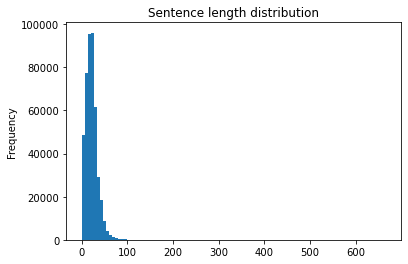

In [14]:
lens = [len(x) for x in train_sentences]
pd.Series(lens).plot.hist(bins=100)
plt.title("First 1000 word distribution")
plt.title("Sentence length distribution")
plt.show()

### Dataset word stats

In [15]:
def dataset_stats(df):
    agg = pd.Series({'uniq_words': len(df),
                     'total_words': df.qty.sum(),
                     'proba_min': df.proba.min(),
                     'proba_max': df.proba.max(),
                     'proba_sum': df.proba.sum()})
    return agg
pd.concat([dataset_stats(df_words).rename('all').to_frame().transpose(),
           df_words.groupby('freq_class').apply(dataset_stats)], axis=0)

,uniq_words,total_words,proba_min,proba_max,proba_sum
all,176733.0,9492148.0,1.053502e-07,7.247643e-02,1.000000
top-10,10.0,2328845.0,7.905692e-03,7.247643e-02,0.245344
top-100,100.0,1836657.0,7.072161e-04,7.832684e-03,0.193492
top-1000,1000.0,2105011.0,1.042967e-04,7.037396e-04,0.221763
top-10000,10000.0,2318738.0,6.847765e-06,1.042967e-04,0.244280
top-100000,100000.0,837274.0,1.053502e-07,6.847765e-06,0.088207
top-1000000,65623.0,65623.0,1.053502e-07,1.053502e-07,0.006913


### Frequencies cluster distribution

<AxesSubplot:xlabel='freq_class'>

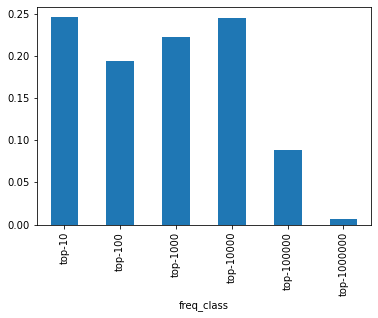

In [16]:
df_words.groupby('freq_class').proba.sum().plot.bar()

### WordSim

In [17]:
def load_ws(ds_root):
    df_ws = pd.read_csv(ds_root/'wordsim353_sim_rel'/'wordsim353_agreed.txt',
                    sep='\t',
                    comment='#',
                    usecols=[1,2,3],
                    names=['word_a',
                           'word_b',
                           'rank'])
    return df_ws

ws = load_ws(EVAL_ROOT)
ws.head()

,word_a,word_b,rank
0,love,sex,6.77
1,tiger,cat,7.35
2,tiger,tiger,10.00
3,book,paper,7.46
4,computer,keyboard,7.62


## Training

In [18]:
centroid_callback = CentroidCalculation()
loss_callback = LossCallback()
hparams_callback = HyperParamLogger(alpha=lambda model: model.min_alpha_yet_reached,
                                    loss=lambda _: loss_callback.loss,
                                    loss_p=lambda _: loss_callback.loss_a,
                                    loss_n=lambda _: loss_callback.loss_b,
                                    dist_mean=lambda _: centroid_callback.dist_mean,
                                    dist_std=lambda _: centroid_callback.dist_std,
                                    corr=lambda model: evaluate_model(model, ws))

w2v = Word2Vec(alpha=0.025,
               min_alpha=0.025,
               workers=cpu_count(),
               vector_size=100,
               window=5,
               min_count=3,
               sg=1,
               negative=5,
               )
w2v.build_vocab(train_sentences, update=False)
idx2word = w2v.wv.index_to_key
word2index = w2v.wv.key_to_index

## Vectors initialization

$$
\left\{\begin{matrix}
W_{i,j}  & \sim & \mathcal{U}\left(-\frac{1}{N}, \frac{1}{N}\right)  \\
C_{i,j}  & = & 0
\end{matrix}\right.
$$

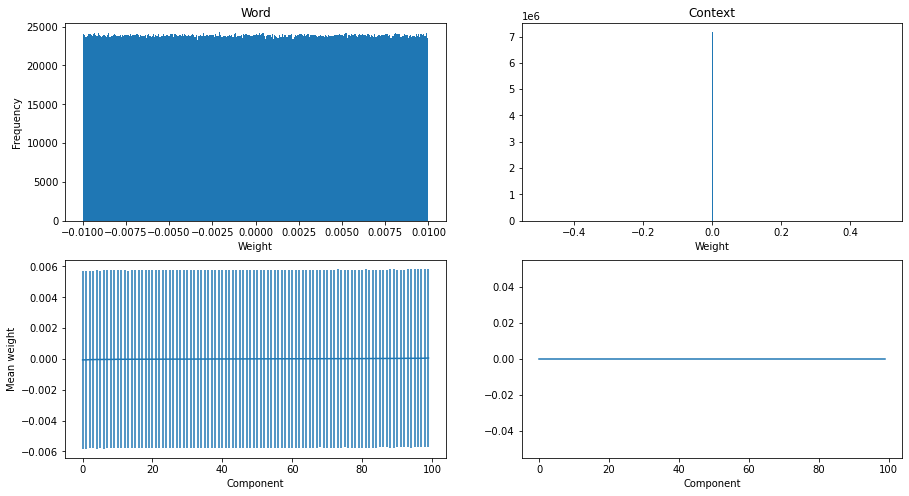

In [19]:
def show_weight_distribution(w2v):
    fig, axs = plt.subplots(figsize=(15,8), ncols=2, nrows=2)
    axs[0][0].set_title('Word')
    axs[0][0].hist(w2v.wv.vectors.flatten(), bins=300)
    axs[0][0].set_ylabel('Frequency')
    axs[0][0].set_xlabel('Weight')
    axs[0][1].set_title('Context')
    axs[0][1].hist(w2v.syn1neg.flatten(), bins=300)
    axs[0][1].set_xlabel('Weight')

    order = np.argsort(w2v.wv.vectors.mean(axis=0))
    axs[1][0].errorbar(np.arange(w2v.vector_size), w2v.wv.vectors.mean(axis=0)[order], w2v.wv.vectors.std(axis=0)[order])
    axs[1][0].set_ylabel('Mean weight')
    axs[1][0].set_xlabel('Component')
    axs[1][1].errorbar(np.arange(w2v.vector_size), w2v.syn1neg.mean(axis=0)[order], w2v.syn1neg.std(axis=0)[order])
    #axs[0][0].set_ylabel('Mean weight')
    axs[1][1].set_xlabel('Component')
    plt.show()
    
show_weight_distribution(w2v)

In [20]:
w2v.train(corpus_iterable=train_sentences,
          total_examples=len(train_sentences),
          callbacks=[centroid_callback,
                     loss_callback,
                     hparams_callback,
                     EpochLogger()],
          compute_loss=True,
          epochs=50)

  0%|          | 0/50 [00:00<?, ?epoch/s]

(363173556, 474607400)

In [21]:
w2v.save(str(MODEL_ROOT/"final_w2v"))

### Testing model

In [22]:
test_words = [
    'money',     'psychology',  'tiger',    'cup',    'stock',   'planet', 'car',
    'precedent', 'drink',       'peace',    'food',   'news',   'game',   'doctor',
    'life',      'dollar',      'computer', 'street', 'movie'
]

df_test_result = pd.DataFrame.from_records([
    {'word': word, 'sim_word': sim_word, 'similarity': round(sim, 2), 'rank': rank}
    for word in test_words
    for rank, (sim_word, sim) in enumerate(w2v.wv.most_similar(word))
]).set_index(['word', 'rank']).unstack(level=1)
df_test_result.columns = df_test_result.columns.swaplevel()
df_test_result.sort_index(axis=1, level=0, inplace=True)
df_test_result

rank                0                      1                          2  \
             sim_word similarity    sim_word similarity        sim_word   
word                                                                      
car           vehicle       0.73        cars       0.70      automobile   
computer    computers       0.75    software       0.69        hardware   
cup              uefa       0.79      finals       0.76    championship   
doctor       harkness       0.62          dr       0.59          mcgann   
dollar            dkr       0.71    ngultrum       0.68          kroner   
drink          drinks       0.71   alcoholic       0.65           honey   
food            foods       0.69  vegetables       0.69        potatoes   
game            games       0.78     console       0.72          arcade   
life            death       0.56     welfare       0.54        personal   
money           loans       0.66        cash       0.65         profits   
movie            film       0.75      movies       0.70           actor   
news         bulletin       0.63         wsb       0.62            espn   
peace         signing       0.64     accords       0.64            pact   
planet        planets       0.74        mars       0.73           earth   
precedent     decisis       0.58   unwritten       0.54  constitutional   
psychology  cognitive       0.73   sociology       0.71    anthropology   
stock          assets       0.62      market       0.62           price   
street        chedoke       0.63      avenue       0.63     flamborough   
tiger        gizmondo       0.62     leopard       0.58           leafs   

rank                            3                           4             \
           similarity    sim_word similarity         sim_word similarity   
word                                                                       
car              0.70  motorcycle       0.67       locomotive       0.63   
computer         0.69   computing       0.68          desktop       0.65   
cup              0.74   champions       0.73       tournament       0.71   
doctor           0.57     surgeon       0.55        physician       0.55   
dollar           0.68       krone       0.66             cfaf       0.66   
drink            0.64        wine       0.63             beer       0.62   
food             0.67   chemicals       0.66          dietary       0.65   
game             0.70       video       0.70         consoles       0.68   
life             0.54        toil       0.53           health       0.52   
money            0.64       funds       0.62          amounts       0.62   
movie            0.67   hollywood       0.66           actors       0.65   
news             0.62         bbc       0.61             wgbs       0.61   
peace            0.62   agreement       0.62           signed       0.60   
planet           0.72       solar       0.68         orbiting       0.67   
precedent        0.54     warrant       0.52  majoritarianism       0.52   
psychology       0.70     science       0.67         sciences       0.67   
stock            0.62    purchase       0.59        investors       0.59   
street           0.61      london       0.61          streets       0.60   
tiger            0.54      jaguar       0.54        thylacine       0.54   

rank                    5                           6             \
                 sim_word similarity         sim_word similarity   
word                                                               
car               bicycle       0.62            motor       0.61   
computer              cpu       0.65        evolvable       0.64   
cup         championships       0.69               fa       0.68   
doctor          torchwood       0.53       pharmacist       0.53   
dollar             forint       0.66          dollars       0.65   
drink            beverage       0.62        beverages       0.61   
food                 fish       0.64      irradiation       0.64

## Experiments results

### Weigth distribution

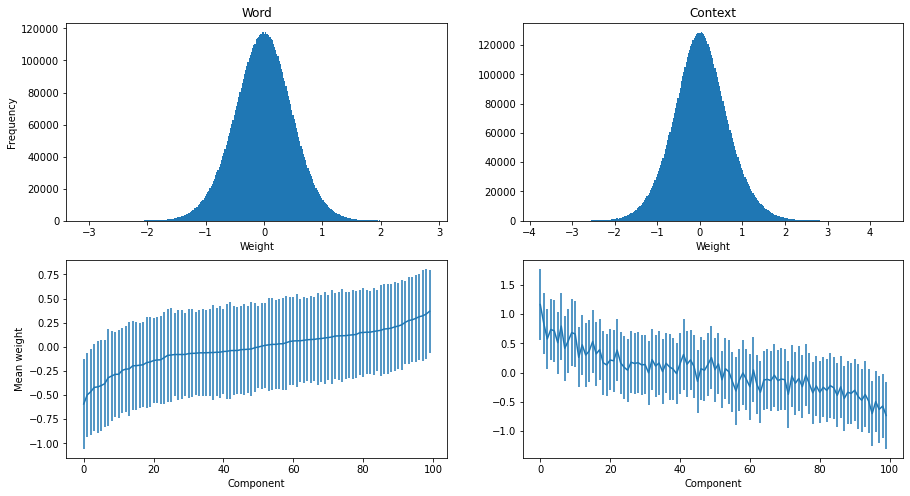

In [23]:
show_weight_distribution(w2v)

### Loss

In [24]:
params_hist = pd.DataFrame.from_records(hparams_callback._params_hist)

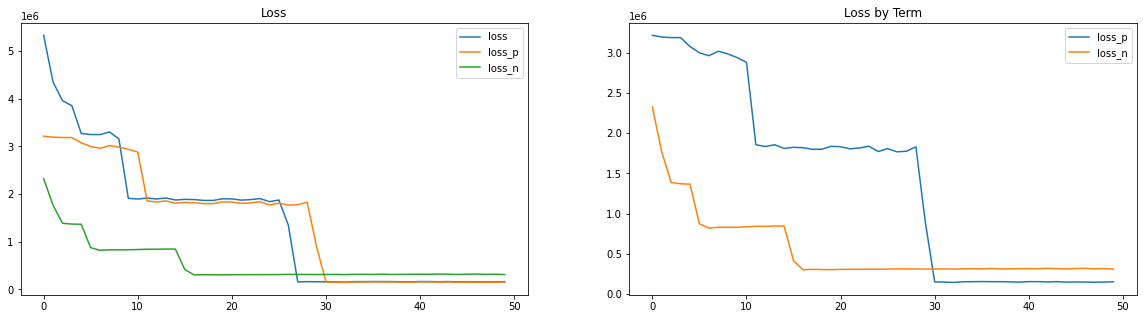

In [25]:
fig, axs = plt.subplots(figsize=(20, 5), ncols=2)
params_hist[['loss', 'loss_p', 'loss_n']].plot(ax=axs[0], title='Loss')
(params_hist[['loss_p', 'loss_n']]).plot(ax=axs[1], title='Loss by Term')
plt.legend()

### WordSim metric

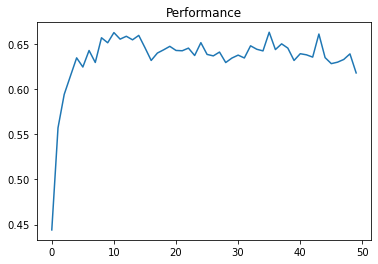

In [26]:
params_hist['corr'].plot(title='Performance')

plt.show()

### Centroid shift

In [27]:
def show_centroid_shift(centroids, epoch_split=3):
    epochs = centroids.shape[0]-1
    shift_norm_centroid_hist = rowise_distance(centroids[1:],centroids[:-1])
    shift_sim_centroid_hist = rowise_cosine_sim(centroids[1:],centroids[:-1])

    fig, axs = plt.subplots(figsize=(20, 10), ncols=3, nrows=2)

    
    axs[0][0].set_title(f"First {epoch_split} epochs")
    axs[0][0].set_ylabel("Distance")
    axs[0][0].plot(range(1,epoch_split+1),shift_norm_centroid_hist[:epoch_split])
    axs[0][1].set_ylabel("Distance")
    axs[0][1].set_title(f"Last {epochs-epoch_split} epochs")
    axs[0][1].plot(range(epoch_split+1,epochs+1),shift_norm_centroid_hist[epoch_split:])
    axs[0][2].set_title(f"All")
    axs[0][2].set_ylabel("Distance")
    axs[0][2].plot(range(1,epochs+1),shift_norm_centroid_hist)

    axs[1][0].set_title(f"First {epoch_split} epochs")
    axs[1][0].set_ylabel("Similarity")
    axs[1][0].plot(range(1,epoch_split+1),shift_sim_centroid_hist[:epoch_split])
    axs[1][1].set_ylabel("Similarity")
    axs[1][1].set_title(f"Last {epochs-epoch_split} epochs")
    axs[1][1].plot(range(epoch_split+1,epochs+1),shift_sim_centroid_hist[epoch_split:])
    axs[1][2].set_title(f"All")
    axs[1][2].set_ylabel("Similarity")
    axs[1][2].plot(range(1,epochs+1),shift_sim_centroid_hist)

Medida de que tan se aleja (en distancia $L^2$ y ánglulo) el centroide al terminar una epocá con respecto al centroide de la epoca anterior

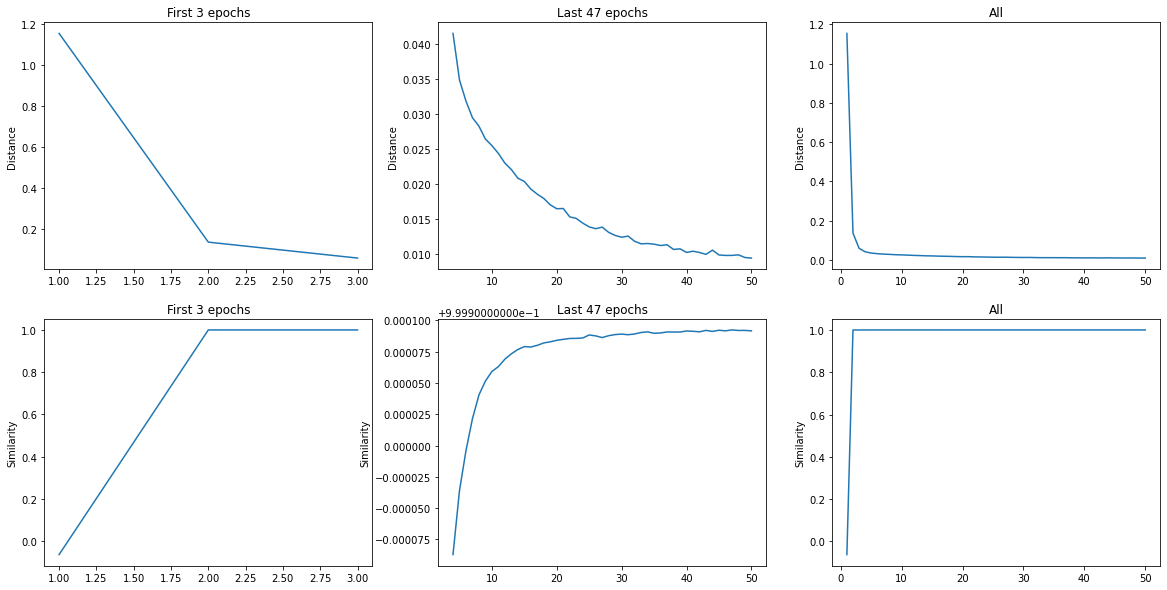

In [28]:
show_centroid_shift(centroid_callback.centroids)
plt.show()

### Centroids Space

Proyección PCA del historial de centroides en el espacio de embeddings

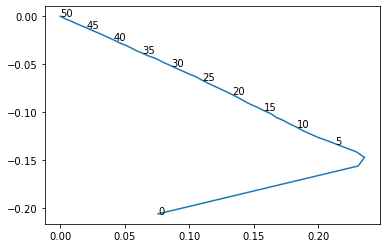

In [29]:
pca=PCA(n_components=2).fit(w2v.wv.vectors)
centroids_reduced = pca.transform(centroid_callback.centroids)
plt.plot(centroids_reduced[:,0], centroids_reduced[:,1])
for i in range(0, centroids_reduced.shape[0], 5):
    plt.text(centroids_reduced[i,0],
             centroids_reduced[i,1],
             str(i))

### Distance to centroid

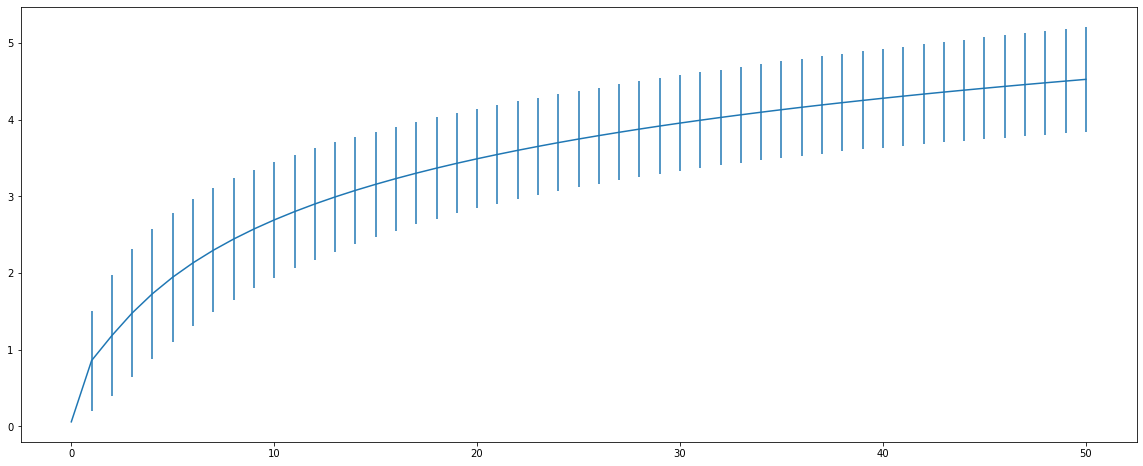

In [30]:
fig = plt.figure(figsize=(20, 8))
ax = fig.gca()
ax.errorbar(x=np.arange(len(centroid_callback._dist_means)), y=centroid_callback._dist_means, yerr=centroid_callback._dist_stds)
plt.show()